# 1. Bank Dataset - Exploratory Data Analysis

The dataset we will use today comes from Kaggle and is called **Binary Classification with a Bank Dataset** which comes from [Kaggle Playground Series!](https://www.kaggle.com/competitions/playground-series-s5e8)

The data were generated using a deep-learning model trained on another [Kaggle competition](https://www.kaggle.com/datasets/sushant097/bank-marketing-dataset-full) and we will use the original dataset from this competition as well to augment our training data.

The task is a binary classification problem: predict whether a client will subscribe to a term deposit given features such as the client’s socioeconomic status.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as stats
from bank_functions import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from umap import UMAP
from sklearn.linear_model import BayesianRidge
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score

# Load the data
df_train = pd.read_csv(r"Data/train.csv")
df_test = pd.read_csv(r"Data/test.csv")

df_orig = pd.read_csv("Data/bank-full.csv", delimiter=";")
df_orig["y"] = df_orig["y"].map({"yes": 1, "no": 0})
df_orig["id"] = (np.arange(len(df_orig)) + 1e6).astype("int")
df_orig = df_orig.set_index("id")

In [26]:
print(f"Train set dimensions : {df_train.shape}")
print(f"Test set dimensions : {df_test.shape}")
df_train.head()

Train set dimensions : (750000, 18)
Test set dimensions : (250000, 17)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [27]:
# Build the summary table 
summary = (
    pd.DataFrame({
        "dtype"    : df_train.dtypes,
        "n_unique" : df_train.nunique(),
        "missing"  : df_train.isna().mean()       
    })
    .assign(missing=lambda df: df["missing"].round(3))
    .sort_values("n_unique", ascending=False)
)

min_miss, max_miss = summary["missing"].min(), summary["missing"].max()

# Let's output the summary with a bit more style
styled_summary = (
    summary
      .style
      .format({"missing": "{:.1%}"})                                # 0.0 % format
      .map(colour_dtype, subset="dtype")                            # colour dtype text
      .map(lambda v: colour_gradient(v, "Reds", min_miss, max_miss),
           subset="missing")                                        # gradient on missing
      .set_properties(subset=["dtype"], **{"text-align": "left"})
)

styled_summary

,dtype,n_unique,missing
id,int64,750000,0.0%
balance,int64,8217,0.0%
duration,int64,1760,0.0%
pdays,int64,596,0.0%
age,int64,78,0.0%
campaign,int64,52,0.0%
previous,int64,50,0.0%
day,int64,31,0.0%
job,object,12,0.0%
month,object,12,0.0%


The dataset is fairly balanced in terms of variable types, with 7 numeric and 9 categorical features. The categorical variables are simple to handle, since most have only a few levels, and even the richest ones contain just 12 categories. This structure suggests that preprocessing and feature engineering should be straightforward, with limited risk of high cardinality issues.

In [4]:
target = "y"
X_cat = ["job","month","poutcome","education","contact","marital","loan","housing","default"]
X_num = ["balance","duration","pdays","age","campaign","previous","day"]

## Target

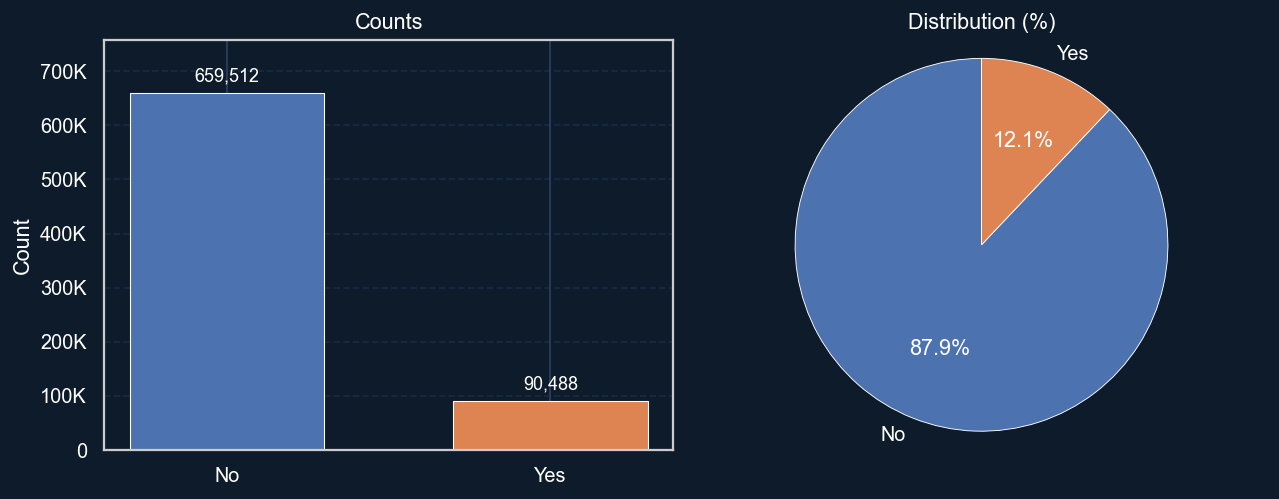

In [30]:

plt.rcParams['figure.dpi'] = 130

c = df_train['y'].dropna().astype(int).value_counts().sort_index()
vals = [c.get(0, 0), c.get(1, 0)]
labels = ['No', 'Yes']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

wedges, _, _ = ax2.pie(vals, labels=labels, autopct=lambda p: f"{p:.1f}%", startangle=90,
                       wedgeprops={'edgecolor': 'white', 'linewidth': 0.5})
ax2.set_title("Distribution (%)")
ax2.axis('equal')

colors = [w.get_facecolor() for w in wedges]
bars = ax1.bar(range(len(labels)), vals, color=colors, width=0.6, edgecolor='white', linewidth=0.6)
ax1.set_xticks(range(len(labels))); ax1.set_xticklabels(labels)
ax1.set_title("Counts"); ax1.set_ylabel("Count"); ax1.grid(axis='y', linestyle='--', alpha=0.4)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(human_fmt))
ymax = max(vals) * 1.15 if max(vals) > 0 else 1
ax1.set_ylim(0, ymax)

offset = ymax * 0.02
for bar, val in zip(bars, vals):
    x0 = bar.get_x() + bar.get_width() / 2
    ax1.annotate(f"{int(val):,}", xy=(x0, bar.get_height() + offset),
                 ha='center', va='bottom', fontsize=10, color='white')

plt.tight_layout()
plt.show()

The target is heavily imbalanced: only 12.1% of observations are “Yes”, which must be considered when training models. This imbalance means that accuracy alone will not be a reliable metric, as a naive model predicting only "No" would already achieve close to 88% accuracy. We will therefore need to focus on metrics such as precision, recall, and AUC.

## Categorical Variables

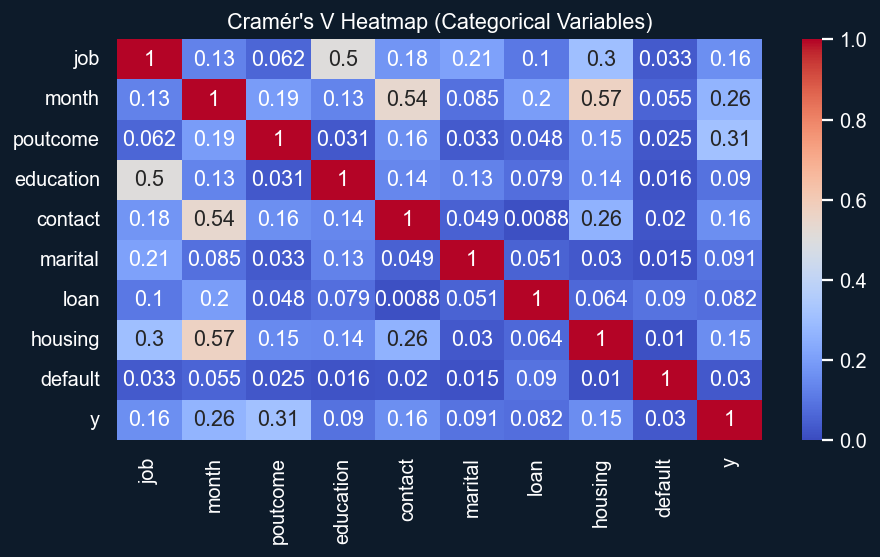

In [6]:
df = df_train[X_cat + ["y"]]

# Create Cramér's V matrix
columns = df.columns
cramers_v_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Plot heatmap
plt.figure(figsize=(8,4))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Heatmap (Categorical Variables)")
plt.show()

The Cramér’s V heatmap indicates that the categorical variables are largely uncorrelated with one another. This indicates that most categorical features bring relatively independent information, reducing the risk of redundancy. The only moderate association observed (0.57 between month and housing) is still far from being a strong correlation, so we can expect each variable to contribute distinct signals during modeling.

In [31]:
anova_results = []
for x in X_cat:
    filtered_df = df_train[[x, target]].dropna()
    groups = [group[target].values for name, group in filtered_df.groupby(x)]
    f_stat, p_value = stats.f_oneway(*groups)
    anova_results.append({'feature': x,'f_stats':f_stat,'p_value': p_value})

anova_df = pd.DataFrame(anova_results)
anova_df = anova_df.sort_values(by='p_value')

anova_df['n_categories'] = anova_df['feature'].apply(lambda f: df_train[f].nunique())
anova_df['eta_squared'] = anova_df['feature'].apply(lambda f: compute_eta_squared(df_train, f, target))
anova_df = anova_df.sort_values(by='eta_squared', ascending=False)
anova_df

,feature,f_stats,p_value,n_categories,eta_squared
2,poutcome,26387.941812,0.000000e+00,4,0.095475
1,month,5108.966422,0.000000e+00,12,0.069709
4,contact,9841.215533,0.000000e+00,3,0.025572
0,job,1729.951448,0.000000e+00,12,0.024745
7,housing,18119.641619,0.000000e+00,2,0.023590
5,marital,3131.154817,0.000000e+00,3,0.008281
3,education,2018.779312,0.000000e+00,4,0.008010
6,loan,5032.211514,0.000000e+00,2,0.006665
8,default,681.652559,3.411715e-150,2,0.000908


The ANOVA results indicate that all categorical features are statistically significant predictors of the binary target (very small p-values). However, the effect sizes (**eta_squared**) vary: *poutcome* and *month* have the strongest associations, while *default* contributes almost nothing.

## Numeric Variables

For numeric variables, we use the point-biserial correlation coefficient (r_pb), which measures the strength and direction of the linear relationship between a binary variable (the target) and a continuous variable (a numeric feature).


=== Univariate EDA summary (ranked) ===
 feature  outlier_rate        mean         std      skew      r_pb      auc  auc_signed  direction
duration      0.061491  256.229144  272.555662  2.048772  0.519283 0.889513    0.889513          1
 balance      0.076993 1204.067397 2836.096759 12.304098  0.122513 0.674945    0.674945          1
previous      0.000000    0.298545    1.335926 13.749858  0.119552 0.579991    0.579991          1
campaign      0.054248    2.577008    2.718514  4.810427 -0.075829 0.421733    0.578267         -1
   pdays      0.000000   22.412733   77.319998  3.625041  0.089277 0.574954    0.574954          1
     day      0.000000   16.117209    8.250832  0.054014 -0.049625 0.454944    0.545056         -1
     age      0.006537   40.926395   10.098829  0.586136  0.009523 0.479485    0.520515         -1


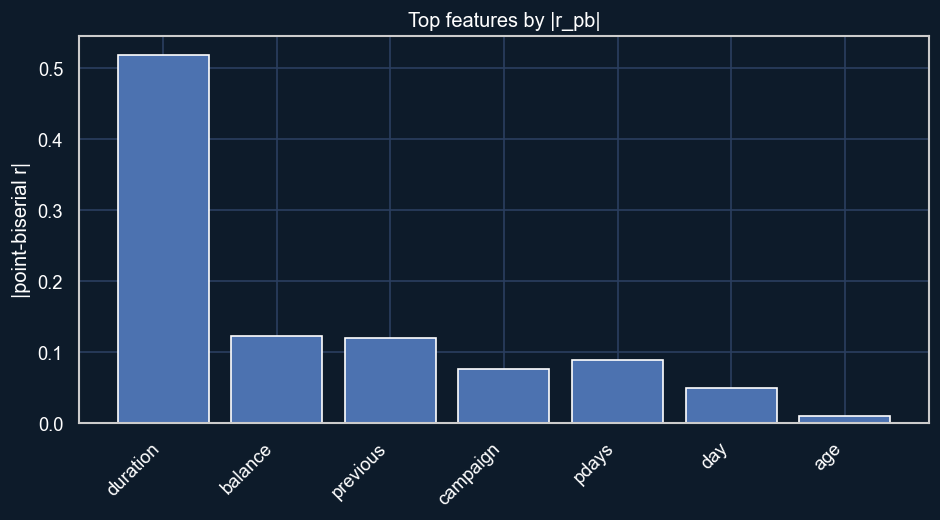

In [8]:
y = df_train[target]
rows = []

for col in X_num:
    x = df_train[col]
    auc = roc_auc_score(y, x)
    direction = 1 if auc >= 0.5 else -1
    auc_signed = auc if direction == 1 else 1 - auc
    r_pb = float(stats.pointbiserialr(y, x).correlation)

    q1, q3 = x.quantile([0.25, 0.75]); iqr = q3 - q1
    out_rate = float(((x < q1 - 1.5*iqr) | (x > q3 + 1.5*iqr)).mean()) if iqr > 0 else 0.0

    rows.append(dict(
        feature=col, outlier_rate=out_rate, mean=float(x.mean()), std=float(x.std(ddof=1)),
        skew=float(stats.skew(x)) if len(x) > 2 else np.nan,
        r_pb=r_pb, auc=auc, auc_signed=auc_signed, direction=direction
    ))

# ---- Summary & quick bar chart ----
summary = (pd.DataFrame(rows)
           .assign(abs_r=lambda d: d.r_pb.abs())
           .sort_values(["auc_signed", "abs_r"], ascending=[False, False])
           .reset_index(drop=True))

cols = ["feature","outlier_rate","mean","std","skew","r_pb","auc","auc_signed","direction"]

print("\n=== Univariate EDA summary (ranked) ===")
print(summary[cols].to_string(index=False))

plt.figure(figsize=(8, 4.5), dpi=120)
plt.bar(summary["feature"], summary["abs_r"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("|point-biserial r|")
plt.title(f"Top features by |r_pb|"); plt.tight_layout(); plt.show()


The analysis shows that the *duration* (of the last contract) stands out as the strongest numeric predictor, with a clear and strong link to the target. Most other numeric features show weaker but still noticeable effects. The impact of age appears to be the weakest.

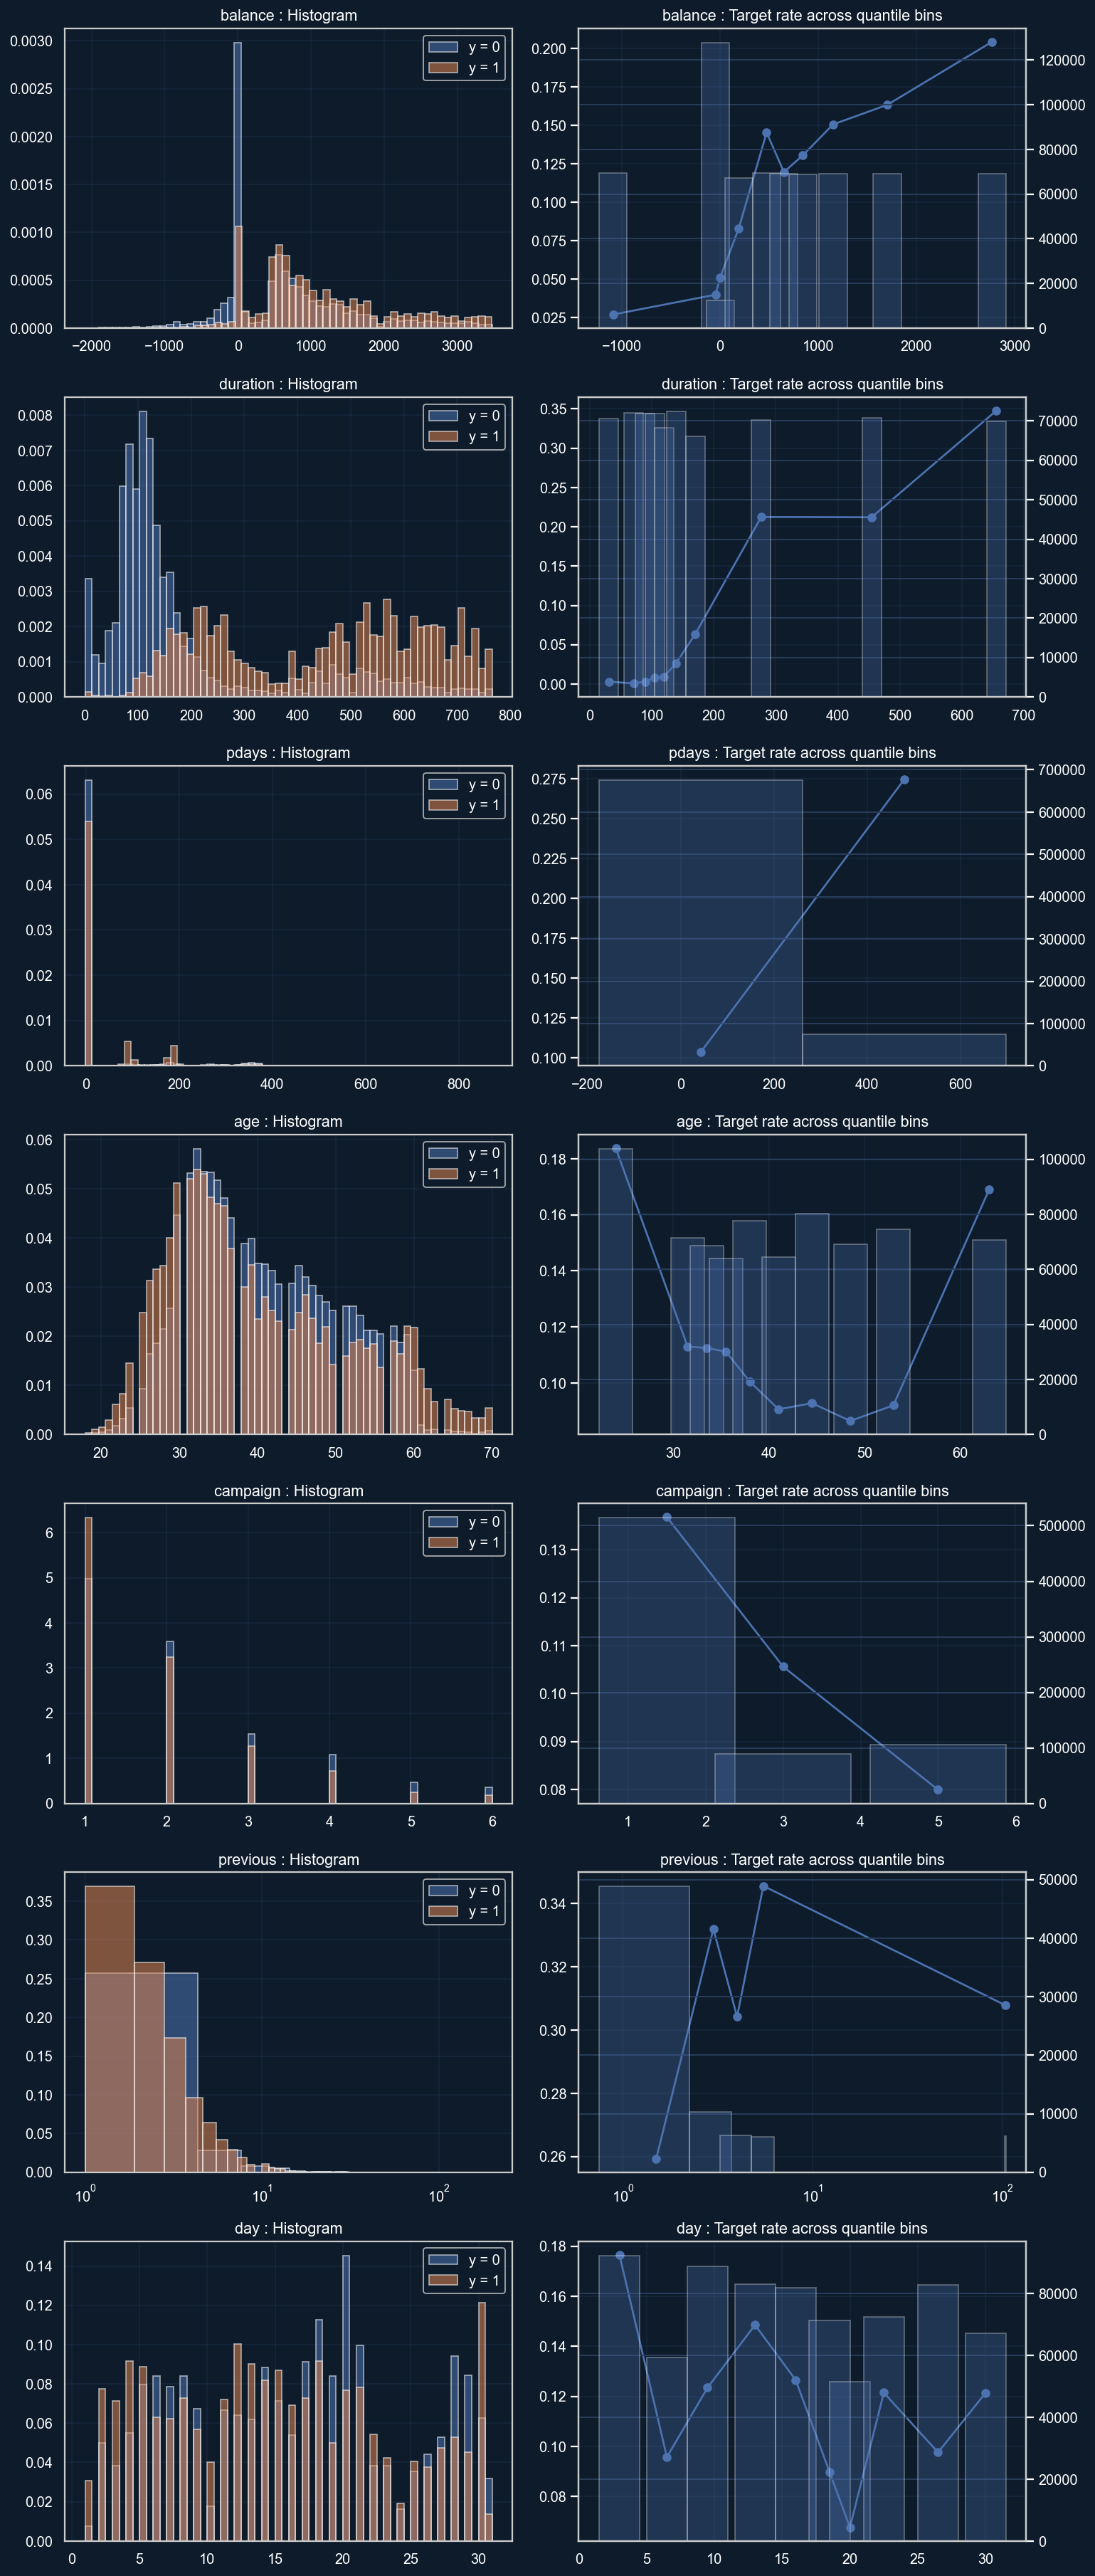

In [49]:
fig, axes = plt.subplots(len(X_num), 2, figsize=(12, 4*len(X_num)))
axes = axes.flatten()

for i, col in enumerate(X_num):
    plot_feature(df_train, col, y, i, log_scale = col in ["previous"], remove_outliers=True)

plt.tight_layout()
plt.show()

The distribution plots confirm that the behaviour of clients who contract and those who do not differs most with respect to the duration of the previous contact.

## Latent Structure

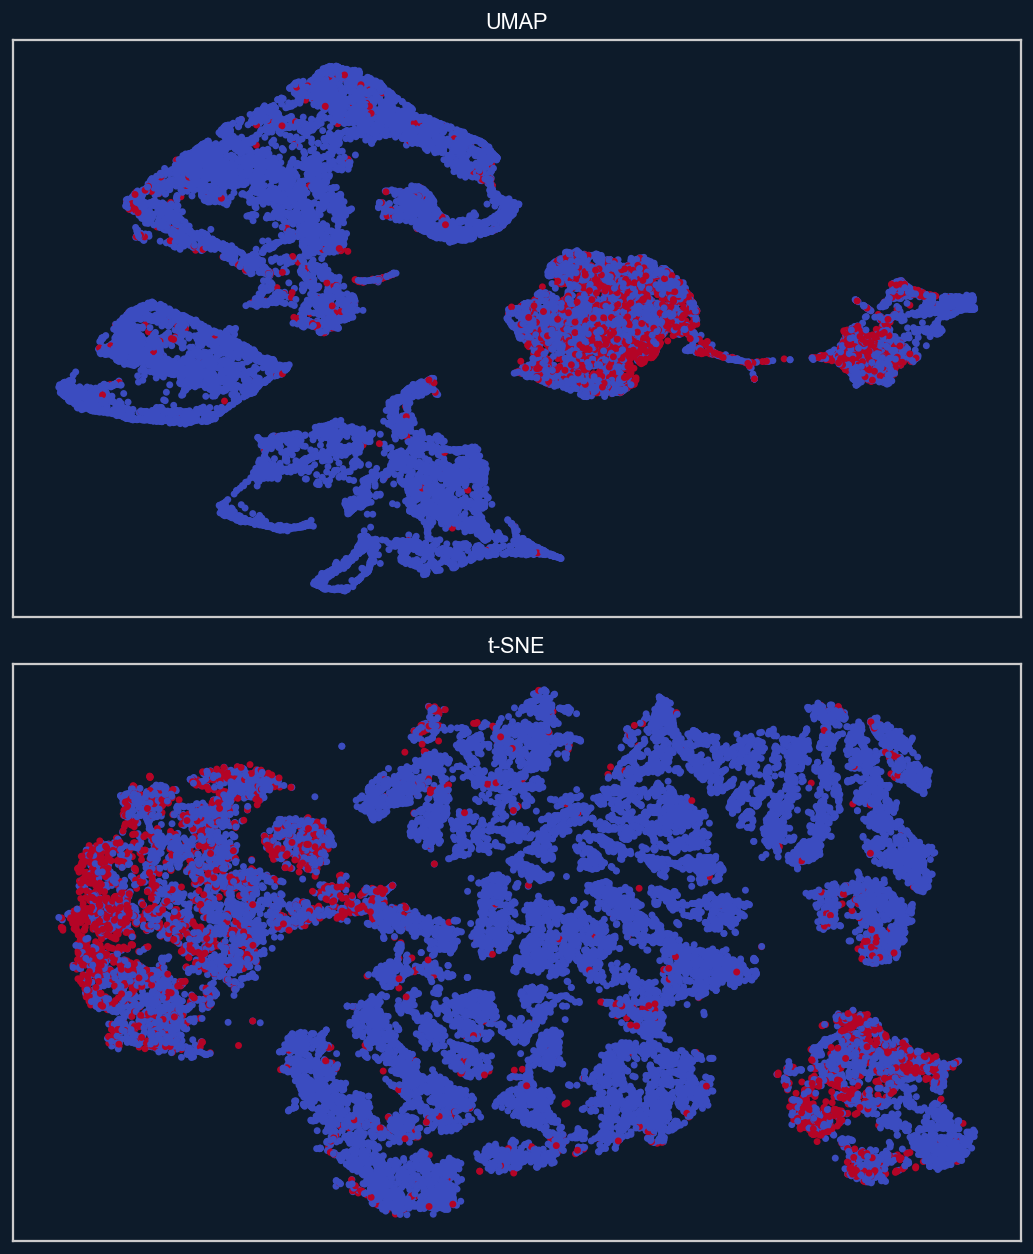

In [10]:
rng = np.random.RandomState(SEED)
N_SAMPLE = 25000
sample_idx = rng.choice(len(df_train), size=N_SAMPLE, replace=False)
X  = df_train.iloc[sample_idx][X_num + X_cat]
y  = df_train.iloc[sample_idx][target]    

# ---------- encoders, imputer, selector ----------------------
enc = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), X_cat),
            ("num", "passthrough", X_num)],
        remainder="drop", sparse_threshold=0
)
iter_imp = IterativeImputer(estimator=BayesianRidge(),max_iter=100,tol=1e-2, random_state=SEED)

# keep only the numeric block (last len(X_num) columns) after imputation
pick_numeric = FunctionTransformer(lambda Z: Z[:, -len(X_num):], validate=False,
                                   feature_names_out="one-to-one")
scaler = StandardScaler()

# ------------------------ pipeline ----------------------------
pipe = Pipeline([
        ("encode", enc),
        ("impute", iter_imp),
        ("pick_numeric", pick_numeric),  
        ("scale", scaler)
])

# ---------------- fit / transform ----------------------------
pipe.fit(X)
umap = UMAP(random_state=None)
X_numeric_imputed_scaled = pipe.transform(X)
emb_umap = umap.fit_transform(X_numeric_imputed_scaled)

tsne = TSNE(n_components=2, perplexity=100, init="random", random_state=SEED, method="barnes_hut")
emb_tsne = tsne.fit_transform(X_numeric_imputed_scaled)

# ------------------------ plot -------------------------------
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(10, 12), dpi=130,
    gridspec_kw={'hspace': 0.08}   
)

ax1.scatter(emb_umap[:, 0], emb_umap[:, 1], c=y, cmap="coolwarm", s=8)
ax2.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=y, cmap="coolwarm", s=8)

ax1.set_title("UMAP")
ax2.set_title("t-SNE")

for ax in (ax1, ax2):
    ax.set_xticks([]); ax.set_yticks([])

plt.show()

Both UMAP and t-SNE show some useful structure: there are distinct islands strongly enriched for the positive class, but many points are mixed, which means the positive class is heterogeneous. There is predictive signal but it’s nonlinearly distributed and we expect better results from nonlinear or cluster-aware models (like tree ensembles).

## Potential Drift

### Train set and Test set

Since we did not perform the train/test split ourselves, it is useful to check for drift between the training and test sets.

In [10]:
# Kolmogorov–Smirnov test for numeric variables
for col in X_num:
    stat, p = stats.ks_2samp(df_train[col], df_test[col])
    print(f"{col}: p={p:.4f}") 
print("")

# Chi Square test for Categorical Variables
for col in X_cat:
    train_counts = df_train[col].value_counts(normalize=True)
    test_counts = df_test[col].value_counts(normalize=True)
    combined = pd.concat([train_counts, test_counts], axis=1).fillna(0)
    stat, p, _, _ = stats.chi2_contingency(combined.values)
    print(f"{col}: p={p:.4f}")

balance: p=0.7273
duration: p=0.5070
pdays: p=1.0000
age: p=0.4197
campaign: p=0.9637
previous: p=1.0000
day: p=0.9915

job: p=1.0000
month: p=1.0000
poutcome: p=1.0000
education: p=1.0000
contact: p=1.0000
marital: p=1.0000
loan: p=1.0000
housing: p=1.0000
default: p=1.0000


For all tests, the p-values exceed the threshold, so we fail to reject the null hypothesis. We detect no drift between the training and test sets for any variable.

### Train set and Original set

In [11]:
# Kolmogorov–Smirnov (KS) test for numeric variables
for col in X_num:
    stat, p = stats.ks_2samp(df_train[col], df_orig[col])
    print(f"{col}: p={p:.4f}") 
print("")

# Chi Square test for Categorical Variables
for col in X_cat + [target]:
    train_counts = df_train[col].value_counts(normalize=True)
    orig_counts = df_orig[col].value_counts(normalize=True)
    combined = pd.concat([train_counts, orig_counts], axis=1).fillna(0)
    stat, p, _, _ = stats.chi2_contingency(combined.values)
    print(f"{col}: p={p:.4f}")

balance: p=0.0000
duration: p=0.0000
pdays: p=0.0000
age: p=0.0000
campaign: p=0.0000
previous: p=0.0000
day: p=0.0000

job: p=1.0000
month: p=1.0000
poutcome: p=0.9989
education: p=0.9999
contact: p=0.9974
marital: p=0.9983
loan: p=1.0000
housing: p=1.0000
default: p=1.0000
y: p=1.0000


Unlike the comparison with the test set, there appears to be drift between the training set and the original dataset: the chi-square tests for categorical variables return p-values near 0, while the KS tests for numeric variables return p-values near 1. 

This suggests that the distributions of categorical features differ significantly between the two datasets, whereas the numeric features appear almost identical. In practice, this means that augmenting the train set with the orig set could introduce inconsistencies; on the other hand, it may also provide new signals not present in the current train data, which could turn out to be even more valuable.

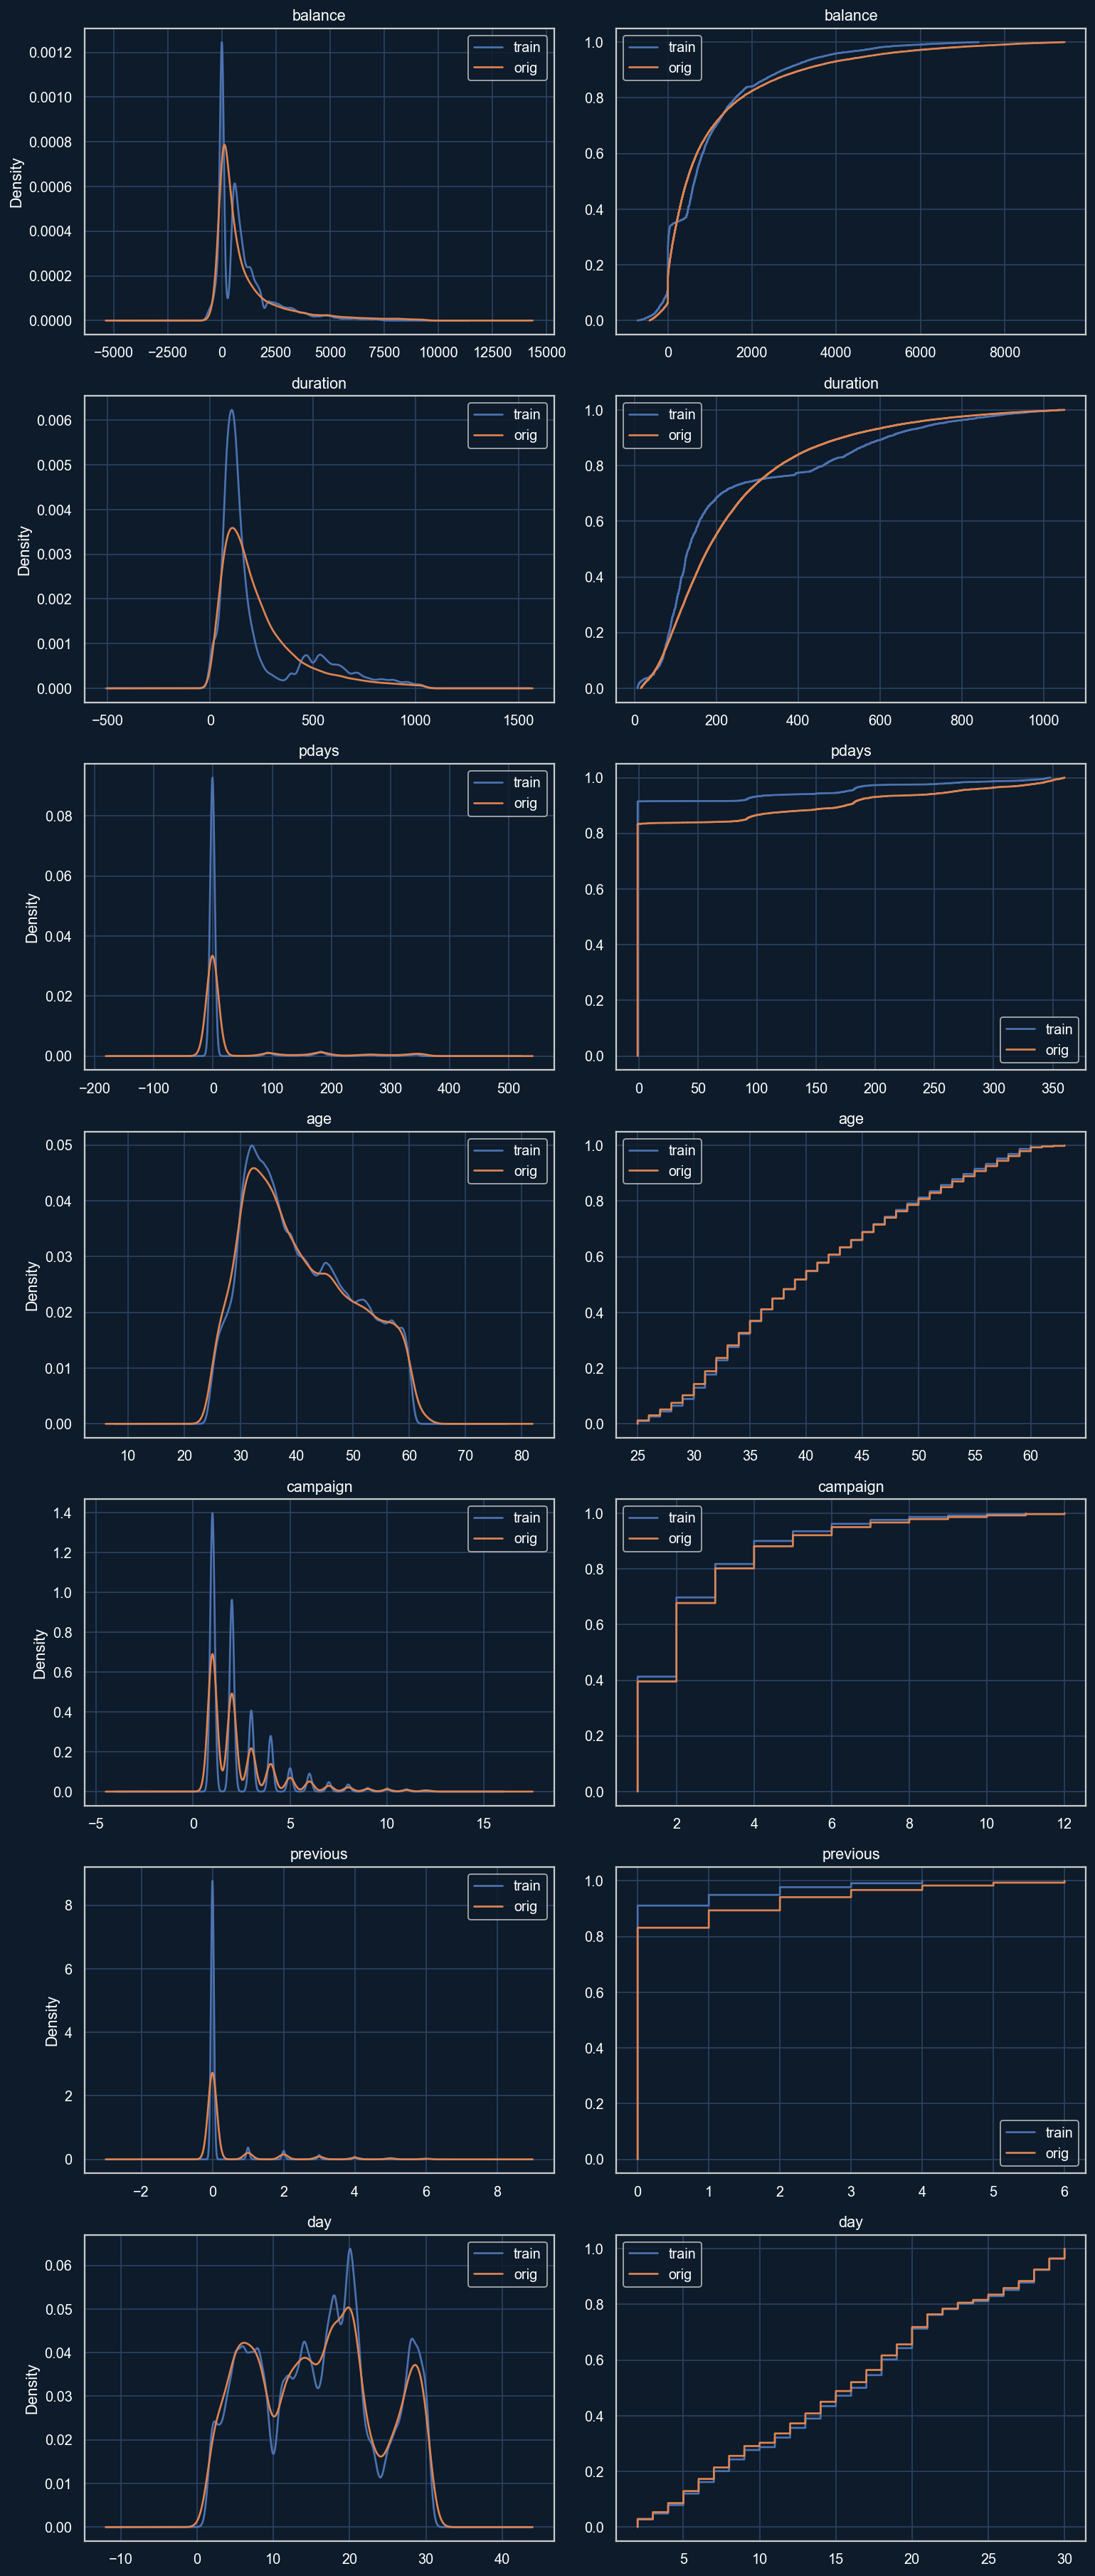

In [23]:
fig, axes = plt.subplots(len(X_num), 2, figsize=(12, 4*len(X_num)))
axes = axes.flatten()

for i, col in enumerate(X_num):
    k = 2*i
    q_min = 0.02
    q_max = 0.98
        
    t = df_train[col]
    o = df_orig[col]
    
    t = t[(t >= t.quantile(q_min)) & (t <= t.quantile(q_max))].sort_values()
    o = o[(o >= o.quantile(q_min)) & (o <= o.quantile(q_max))].sort_values()
    
    t.plot(kind="density", ax=axes[k], label="train")
    o.plot(kind="density", ax=axes[k], label="orig")
    axes[k].set_title(col)
    axes[k].legend()
    
    yt = np.arange(1, len(t)+1)/len(t)
    yo = np.arange(1, len(o)+1)/len(o)
    axes[k+1].step(t, yt, where="post", label="train")
    axes[k+1].step(o, yo, where="post", label="orig")
    axes[k+1].set_title(col)
    axes[k+1].legend()


plt.tight_layout()
plt.show()

Examining the distributions and empirical distribution functions (EDFs) of numeric variables, most features appear well aligned between the training and original datasets. Age, balance, and day show almost identical shapes and cumulative behavior, suggesting no meaningful drift. Variables such as pdays and previous are also broadly consistent, with only minor differences in how non-zero values are spread. On the other hand, duration and campaign stand out: the train set shows sharper peaks, while the orig set is smoother and allocates more mass to longer or higher values. These differences point to a moderate drift in how those features are represented across the two datasets.

We are now ready to move to the Modeling part in the [Next Notebook](2_Bank_ML.ipynb)